In [159]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [160]:
newdf = pd.read_excel("Volve production data.xlsx")

In [161]:
columns_to_fill = [
    'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING',
    'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P',
    'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL'
]
for column in columns_to_fill:
    newdf[column] = newdf[column].ffill()

In [162]:
to_drop = ["WELL_BORE_CODE", "NPD_WELL_BORE_NAME","NPD_WELL_BORE_CODE", "NPD_FIELD_NAME", "NPD_FIELD_CODE", "NPD_FACILITY_CODE", "NPD_FACILITY_NAME","BORE_WI_VOL","AVG_CHOKE_UOM","FLOW_KIND","WELL_TYPE","BORE_OIL_VOL","BORE_GAS_VOL","BORE_WAT_VOL" ]
newdfmodel = newdf.drop(to_drop, axis=1)
print(newdfmodel.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15634 entries, 0 to 15633
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATEPRD                   15634 non-null  datetime64[ns]
 1   ON_STREAM_HRS             15634 non-null  float64       
 2   AVG_DOWNHOLE_PRESSURE     15634 non-null  float64       
 3   AVG_DOWNHOLE_TEMPERATURE  15634 non-null  float64       
 4   AVG_DP_TUBING             15634 non-null  float64       
 5   AVG_ANNULUS_PRESS         15634 non-null  float64       
 6   AVG_CHOKE_SIZE_P          15634 non-null  float64       
 7   AVG_WHP_P                 15634 non-null  float64       
 8   AVG_WHT_P                 15634 non-null  float64       
 9   DP_CHOKE_SIZE             15634 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 1.2 MB
None


In [163]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [164]:
# Tomar los datos de los pozos 2 a 4, ya que tienen el menor número de valores faltantes
newdfmodel.reset_index(drop=True, inplace=True)
fdf = newdfmodel.loc[746:1910]

X = fdf.drop(['AVG_DOWNHOLE_PRESSURE'], axis=1)
y = fdf[['AVG_DOWNHOLE_PRESSURE']]

# Escalar tus características si es necesario
#scaler = MinMaxScaler(feature_range=(0, 1))
#X[['ON_STREAM_HRS', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_WAT_VOL']] = scaler.fit_transform(X[['ON_STREAM_HRS', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_WAT_VOL']])

# Definir la división temporal utilizando TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=3)
train_scores = []
test_scores = []

# Iterar sobre las divisiones temporales y entrenar/evaluar el modelo
for train_index, test_index in time_series_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Eliminar columnas que no deben ir para la corrida del modelo
    x_train_final = X_train.drop(['DATEPRD'], axis=1)
    x_test_final = X_test.drop(['DATEPRD'], axis=1)
    y_test_final = y_test['AVG_DOWNHOLE_PRESSURE']
    y_train_final = y_train['AVG_DOWNHOLE_PRESSURE']

    # Inicializar y entrenar el modelo (usé LinearRegression como ejemplo)
    reg_model = LinearRegression()
    reg_model.fit(x_train_final, y_train_final)

    #Hacer predicciones en los conjuntos de entrenamiento y de prueba
    train_predictions = reg_model.predict(x_train_final)
    test_predictions = reg_model.predict(x_test_final)

# Calcular métricas de entrenamiento y de prueba
    train_mse = mean_squared_error(y_train, train_predictions)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    test_mse = mean_squared_error(y_test, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Agregar las métricas a las listas
    train_scores.append((train_mse, train_rmse, train_mae, train_r2))
    test_scores.append((test_mse, test_rmse, test_mae, test_r2))

# Imprimir las métricas de entrenamiento y de prueba en cada división
for i, (train_score, test_score) in enumerate(zip(train_scores, test_scores)):
    print(f"Split {i+1}:")
    print("Training MSE:", train_score[0])
    print("Training RMSE:", train_score[1])
    print("Training MAE:", train_score[2])
    print("Training R2:", train_score[3])
    print("Test MSE:", test_score[0])
    print("Test RMSE:", test_score[1])
    print("Test MAE:", test_score[2])
    print("Test R2:", test_score[3])
    print()

Split 1:
Training MSE: 3.623905762242492
Training RMSE: 1.9036558938638286
Training MAE: 0.9501528880800265
Training R2: 0.9991663645025675
Test MSE: 11.69746291881729
Test RMSE: 3.4201553939576037
Test MAE: 2.115864636338385
Test R2: 0.9785373703224944

Split 2:
Training MSE: 2.788960585590345
Training RMSE: 1.6700181392997937
Training MAE: 0.7810108370187019
Training R2: 0.9988621578705518
Test MSE: 508.3113679626706
Test RMSE: 22.54576164077565
Test MAE: 15.933834019004301
Test R2: -0.6582691041306499

Split 3:
Training MSE: 2.718979716608894
Training RMSE: 1.6489329023974548
Training MAE: 0.48090038227925247
Training R2: 0.9984568948644591
Test MSE: 2.827190094685556
Test RMSE: 1.6814250190494835
Test MAE: 1.4742430378343672
Test R2: 0.9840808148384159



In [96]:
y_test

,AVG_DOWNHOLE_PRESSURE
1620,220.775706
1621,220.900410
1622,220.168261
1623,220.518801
1624,220.783583
...,...
1906,253.399422
1907,253.209915
1908,252.938710
1909,252.892344


In [130]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Supongamos que 'newdfmodel' contiene tus datos originales

# Tomar los datos de los pozos 2 a 4, ya que tienen el menor número de valores faltantes
newdfmodel.reset_index(drop=True, inplace=True)
fdf = newdfmodel.loc[746:1910]

X = fdf.drop(['AVG_DOWNHOLE_PRESSURE'], axis=1)
y = fdf[['AVG_DOWNHOLE_PRESSURE']]

# Definir el número de divisiones para que el conjunto de prueba sea aproximadamente el 25% de los datos
n_splits = 3

# Definir la división temporal utilizando TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=n_splits)

# Inicializar listas para almacenar las métricas de entrenamiento y de prueba en cada iteración
train_scores = []
test_scores = []

# Iterar sobre las divisiones temporales y entrenar/evaluar el modelo
for train_index, test_index in time_series_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Eliminar columnas que no deben ir para la corrida del modelo
    x_train_final = X_train.drop(['DATEPRD'], axis=1)
    x_test_final = X_test.drop(['DATEPRD'], axis=1)
    y_test_final = y_test['AVG_DOWNHOLE_PRESSURE']
    y_train_final = y_train['AVG_DOWNHOLE_PRESSURE']

    # Inicializar y entrenar el modelo (usé LinearRegression como ejemplo)
    reg_model = LinearRegression()
    reg_model.fit(x_train_final, y_train_final)

    # Hacer predicciones en los conjuntos de entrenamiento y de prueba
    train_predictions = reg_model.predict(x_train_final)
    test_predictions = reg_model.predict(x_test_final)

    # Calcular métricas de entrenamiento y de prueba
    train_mse = mean_squared_error(y_train_final, train_predictions)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train_final, train_predictions)
    train_r2 = r2_score(y_train_final,train_predictions)

    test_mse = mean_squared_error(y_test_final, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test_final, test_predictions)
    test_r2 = r2_score(y_test_final, test_predictions)

    # Agregar las métricas a las listas
    train_scores.append((train_mse, train_rmse, train_mae, train_r2))
    test_scores.append((test_mse, test_rmse, test_mae, test_r2))

    # Convertir las listas de métricas en un DataFrame
metrics_df = pd.DataFrame({
    'Train MSE': [score[0] for score in train_scores],
    'Train RMSE': [score[1] for score in train_scores],
    'Train MAE': [score[2] for score in train_scores],
    'Train R2': [score[3] for score in train_scores],
    'Test MSE': [score[0] for score in test_scores],
    'Test RMSE': [score[1] for score in test_scores],
    'Test MAE': [score[2] for score in test_scores],
    'Test R2': [score[3] for score in test_scores]
})



In [131]:
metrics_df

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,3.623906,1.903656,0.950153,0.999166,11.697463,3.420155,2.115865,0.978537
1,2.788961,1.670018,0.781011,0.998862,508.311368,22.545762,15.933834,-0.658269
2,2.718980,1.648933,0.480900,0.998457,2.827190,1.681425,1.474243,0.984081


In [132]:
avg_metrics=metrics_df.mean()
avg_metrics

Train MSE       3.043949
Train RMSE      1.740869
Train MAE       0.737355
Train R2        0.998828
Test MSE      174.278674
Test RMSE       9.215781
Test MAE        6.507981
Test R2         0.434783
dtype: float64

In [134]:
# Calcular el promedio de las métricas
import pandas as pd
# Suponiendo que avg_metrics es un objeto Series que contiene los promedios de las métricas
avg_metrics_df = avg_metrics.to_frame().T
avg_metrics_df

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,3.043949,1.740869,0.737355,0.998828,174.278674,9.215781,6.507981,0.434783


In [135]:
# Obtener las fechas correspondientes al conjunto de prueba
test_dates = X_test['DATEPRD']
train_dates= X_train['DATEPRD']

    # Crear un DataFrame con las fechas, predicciones y valores reales
results_train=pd.DataFrame({'Date': train_dates, 'Predicted': train_predictions , 'Actual': y_train_final})
results_df = pd.DataFrame({'Date': test_dates, 'Predicted': test_predictions , 'Actual': y_test_final})


In [ ]:
results_train.shape

(874, 3)

In [ ]:
results_df.shape

(291, 3)

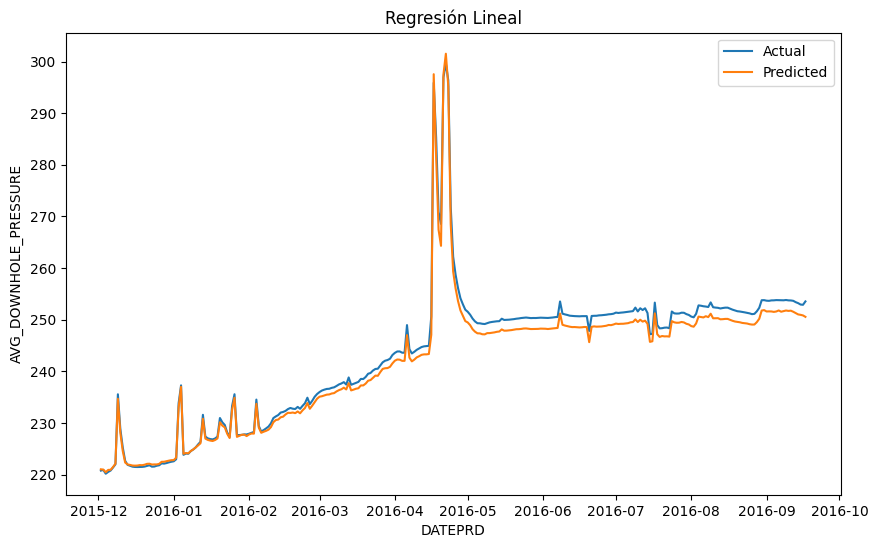

In [136]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual')
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted')
plt.title('Regresión Lineal')
plt.xlabel('DATEPRD')
plt.ylabel('AVG_DOWNHOLE_PRESSURE')
plt.legend()
plt.show()

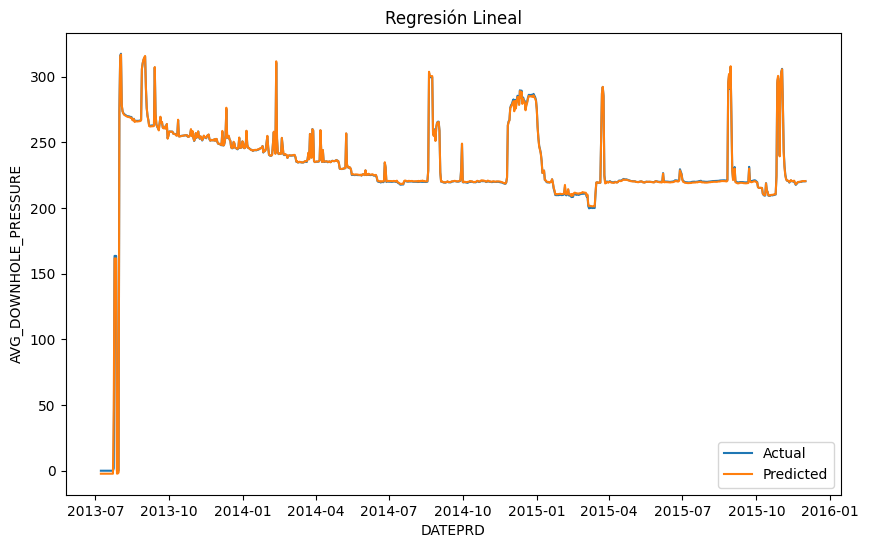

In [137]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(results_train['Date'], results_train['Actual'], label='Actual')
plt.plot(results_train['Date'], results_train['Predicted'], label='Predicted')
plt.title('Regresión Lineal')
plt.xlabel('DATEPRD')
plt.ylabel('AVG_DOWNHOLE_PRESSURE')
plt.legend()
plt.show()

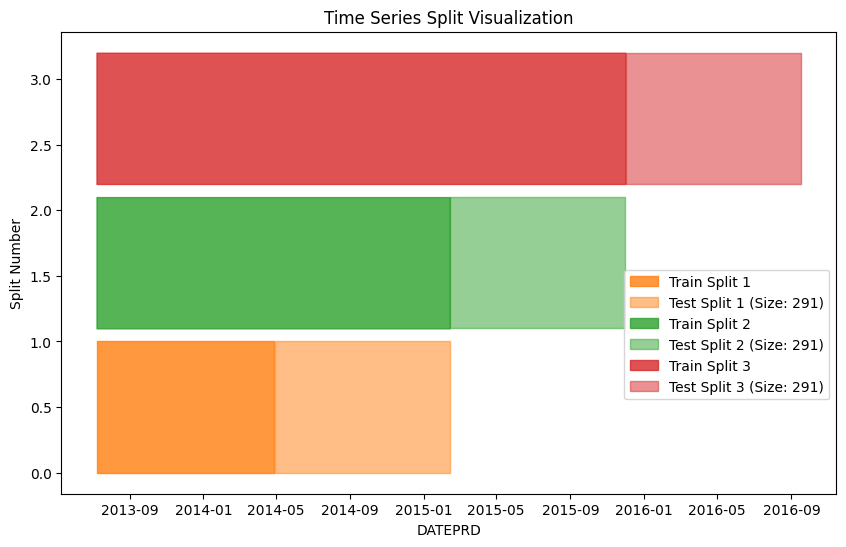

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que 'newdfmodel' contiene tus datos originales

# Tomar los datos de los pozos 2 a 4, ya que tienen el menor número de valores faltantes
newdfmodel.reset_index(drop=True, inplace=True)
fdf = newdfmodel.loc[746:1910]

X = fdf.drop(['AVG_DOWNHOLE_PRESSURE'], axis=1)
y = fdf[['AVG_DOWNHOLE_PRESSURE']]

# Definir la división temporal utilizando TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=3)

# Crear un gráfico para visualizar las divisiones
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(time_series_split.split(X)):
    # Calcular las alturas y el espacio entre los rectángulos
    rectangle_height = 1
    space_between_rectangles = 0.1

    train_dates = X['DATEPRD'].iloc[train_index]
    test_dates = X['DATEPRD'].iloc[test_index]

    # Dibujar rectángulos para resaltar las divisiones de entrenamiento y prueba
    ax.fill_between(train_dates, i * (rectangle_height + space_between_rectangles),
                    (i + 1) * (rectangle_height + space_between_rectangles) - space_between_rectangles,
                    color=f'C{i + 1}', label=f'Train Split {i + 1}', alpha=0.8)

    ax.fill_between(test_dates, i * (rectangle_height + space_between_rectangles),
                    (i + 1) * (rectangle_height + space_between_rectangles) - space_between_rectangles,
                    color=f'C{i + 1}', alpha=0.5, label=f'Test Split {i + 1} (Size: {len(test_index)})')  # Agregar el tamaño del conjunto de prueba

# Configurar la leyenda y etiquetas del eje
ax.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('DATEPRD')
ax.set_ylabel('Split Number')
ax.set_title('Time Series Split Visualization')

plt.show()


**Regresion Ridge**

In [138]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Supongamos que 'newdfmodel' contiene tus datos originales

# Tomar los datos de los pozos 2 a 4, ya que tienen el menor número de valores faltantes
newdfmodel.reset_index(drop=True, inplace=True)
fdf = newdfmodel.loc[746:1910]

X = fdf.drop(['AVG_DOWNHOLE_PRESSURE'], axis=1)
y = fdf[['AVG_DOWNHOLE_PRESSURE']]

# Definir el número de divisiones para que el conjunto de prueba sea aproximadamente el 25% de los datos
n_splits = 3

# Definir la división temporal utilizando TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=n_splits)

# Inicializar listas para almacenar las métricas de entrenamiento y de prueba en cada iteración
train_scores = []
test_scores = []

# Iterar sobre las divisiones temporales y entrenar/evaluar el modelo
for train_index, test_index in time_series_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Eliminar columnas que no deben ir para la corrida del modelo
    x_train_final = X_train.drop(['DATEPRD'], axis=1)
    x_test_final = X_test.drop(['DATEPRD'], axis=1)
    y_test_final = y_test['AVG_DOWNHOLE_PRESSURE']
    y_train_final = y_train['AVG_DOWNHOLE_PRESSURE']

    # Inicializar y entrenar el modelo (usé LinearRegression como ejemplo)
    ridge_model = Ridge(alpha=1)
    ridge_model.fit(x_train_final, y_train_final)

    # Hacer predicciones en los conjuntos de entrenamiento y de prueba
    train_predictions = ridge_model.predict(x_train_final)
    test_predictions = ridge_model.predict(x_test_final)

    # Calcular métricas de entrenamiento y de prueba
    train_mse = mean_squared_error(y_train_final, train_predictions)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train_final, train_predictions)
    train_r2 = r2_score(y_train_final,train_predictions)

    test_mse = mean_squared_error(y_test_final, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test_final, test_predictions)
    test_r2 = r2_score(y_test_final, test_predictions)

    # Agregar las métricas a las listas
    train_scores.append((train_mse, train_rmse, train_mae, train_r2))
    test_scores.append((test_mse, test_rmse, test_mae, test_r2))

    # Convertir las listas de métricas en un DataFrame
metrics_df1 = pd.DataFrame({
    'Train MSE': [score[0] for score in train_scores],
    'Train RMSE': [score[1] for score in train_scores],
    'Train MAE': [score[2] for score in train_scores],
    'Train R2': [score[3] for score in train_scores],
    'Test MSE': [score[0] for score in test_scores],
    'Test RMSE': [score[1] for score in test_scores],
    'Test MAE': [score[2] for score in test_scores],
    'Test R2': [score[3] for score in test_scores]
})


In [139]:
metrics_df1

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,3.624024,1.903687,0.949581,0.999166,11.550992,3.398675,2.098519,0.978806
1,2.788966,1.670020,0.780226,0.998862,505.803096,22.490067,15.896690,-0.650086
2,2.718980,1.648933,0.481090,0.998457,2.829665,1.682161,1.474904,0.984067


In [140]:
avg_metrics=metrics_df1.mean()
avg_metrics

Train MSE       3.043990
Train RMSE      1.740880
Train MAE       0.736966
Train R2        0.998828
Test MSE      173.394584
Test RMSE       9.190301
Test MAE        6.490038
Test R2         0.437596
dtype: float64

In [141]:
# Calcular el promedio de las métricas
import pandas as pd

# Suponiendo que avg_metrics es un objeto Series que contiene los promedios de las métricas
avg_metrics_df = avg_metrics.to_frame().T
avg_metrics_df

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,3.04399,1.74088,0.736966,0.998828,173.394584,9.190301,6.490038,0.437596


In [142]:
#Obtener las fechas correspondientes al conjunto de prueba
test_dates = X_test['DATEPRD']
train_dates= X_train['DATEPRD']

    # Crear un DataFrame con las fechas, predicciones y valores reales
results_train=pd.DataFrame({'Date': train_dates, 'Predicted': train_predictions , 'Actual': y_train_final})
results_test = pd.DataFrame({'Date': test_dates, 'Predicted': test_predictions , 'Actual': y_test_final})


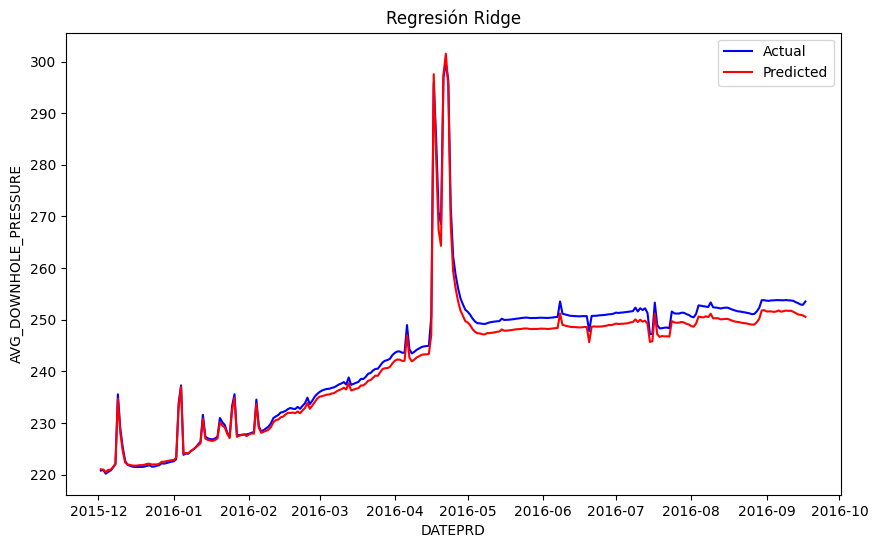

In [143]:
import matplotlib.pyplot as plt
import pandas as pd

# Supongamos que results_df contiene tus datos de resultados

# Graficar los resultados
plt.figure(figsize=(10, 6))

plt.plot(results_test['Date'], results_test['Actual'], label='Actual',color='Blue')
plt.plot(results_test['Date'], results_test['Predicted'], label='Predicted',color='red')

plt.title('Regresión Ridge')
plt.xlabel('DATEPRD')
plt.ylabel('AVG_DOWNHOLE_PRESSURE')
plt.legend()

plt.show()


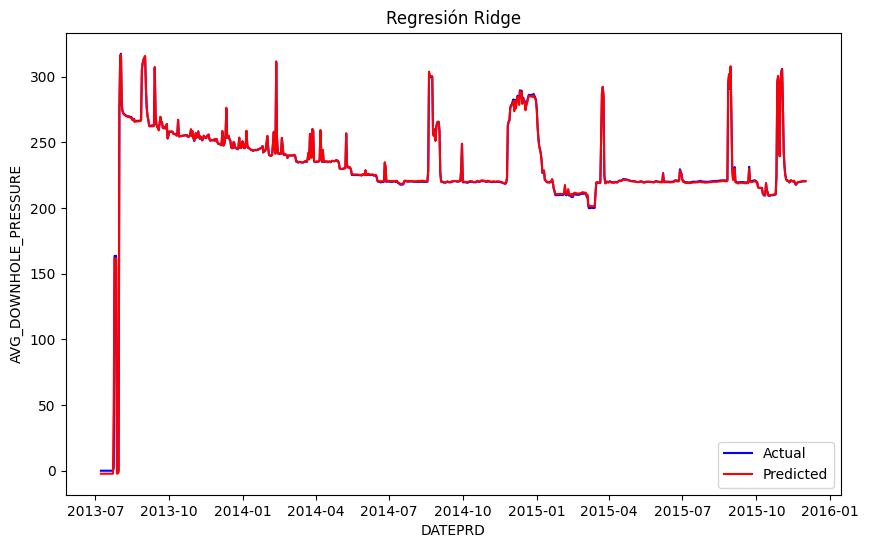

In [145]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(results_train['Date'], results_train['Actual'], label='Actual',color='Blue')
plt.plot(results_train['Date'], results_train['Predicted'], label='Predicted', color='Red')
plt.title('Regresión Ridge')
plt.xlabel('DATEPRD')
plt.ylabel('AVG_DOWNHOLE_PRESSURE')
plt.legend()
plt.show()

**Regresion Lasso**

In [147]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Supongamos que 'newdfmodel' contiene tus datos originales

# Tomar los datos de los pozos 2 a 4, ya que tienen el menor número de valores faltantes
newdfmodel.reset_index(drop=True, inplace=True)
fdf = newdfmodel.loc[746:1910]

X = fdf.drop(['AVG_DOWNHOLE_PRESSURE'], axis=1)
y = fdf[['AVG_DOWNHOLE_PRESSURE']]

# Definir el número de divisiones para que el conjunto de prueba sea aproximadamente el 25% de los datos
n_splits = 3

# Definir la división temporal utilizando TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=n_splits)

# Inicializar listas para almacenar las métricas de entrenamiento y de prueba en cada iteración
train_scores = []
test_scores = []

# Iterar sobre las divisiones temporales y entrenar/evaluar el modelo
for train_index, test_index in time_series_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Eliminar columnas que no deben ir para la corrida del modelo
    x_train_final = X_train.drop(['DATEPRD'], axis=1)
    x_test_final = X_test.drop(['DATEPRD'], axis=1)
    y_test_final = y_test['AVG_DOWNHOLE_PRESSURE']
    y_train_final = y_train['AVG_DOWNHOLE_PRESSURE']

    lasso_model = Lasso(alpha=1.0)
    lasso_model.fit(x_train_final, y_train_final)

     # Hacer predicciones en los conjuntos de entrenamiento y de prueba
    train_predictions = lasso_model.predict(x_train_final)
    test_predictions = lasso_model.predict(x_test_final)

    # Calcular métricas de entrenamiento y de prueba
    train_mse = mean_squared_error(y_train_final, train_predictions)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train_final, train_predictions)
    train_r2 = r2_score(y_train_final,train_predictions)

    test_mse = mean_squared_error(y_test_final, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test_final, test_predictions)
    test_r2 = r2_score(y_test_final, test_predictions)

    # Agregar las métricas a las listas
    train_scores.append((train_mse, train_rmse, train_mae, train_r2))
    test_scores.append((test_mse, test_rmse, test_mae, test_r2))

    # Convertir las listas de métricas en un DataFrame
metrics_df2 = pd.DataFrame({
    'Train MSE': [score[0] for score in train_scores],
    'Train RMSE': [score[1] for score in train_scores],
    'Train MAE': [score[2] for score in train_scores],
    'Train R2': [score[3] for score in train_scores],
    'Test MSE': [score[0] for score in test_scores],
    'Test RMSE': [score[1] for score in test_scores],
    'Test MAE': [score[2] for score in test_scores],
    'Test R2': [score[3] for score in test_scores]
})


In [148]:
metrics_df2

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,4.551134,2.133339,0.838218,0.998953,6.188066,2.487582,1.371072,0.988646
1,3.724707,1.929950,0.447076,0.998480,2.358098,1.535610,1.402653,0.992307
2,2.867082,1.693246,0.247028,0.998373,0.220348,0.469412,0.426377,0.998759


In [149]:
avg_metrics=metrics_df2.mean()
avg_metrics

Train MSE     3.714308
Train RMSE    1.918845
Train MAE     0.510774
Train R2      0.998602
Test MSE      2.922171
Test RMSE     1.497535
Test MAE      1.066701
Test R2       0.993238
dtype: float64

In [150]:
# Calcular el promedio de las métricas
import pandas as pd

# Suponiendo que avg_metrics es un objeto Series que contiene los promedios de las métricas
avg_metrics_df = avg_metrics.to_frame().T
avg_metrics_df

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,3.714308,1.918845,0.510774,0.998602,2.922171,1.497535,1.066701,0.993238


In [151]:
#Obtener las fechas correspondientes al conjunto de prueba
test_dates = X_test['DATEPRD']
train_dates= X_train['DATEPRD']

    # Crear un DataFrame con las fechas, predicciones y valores reales
results_train=pd.DataFrame({'Date': train_dates, 'Predicted': train_predictions , 'Actual': y_train_final})
results_test = pd.DataFrame({'Date': test_dates, 'Predicted': test_predictions , 'Actual': y_test_final})


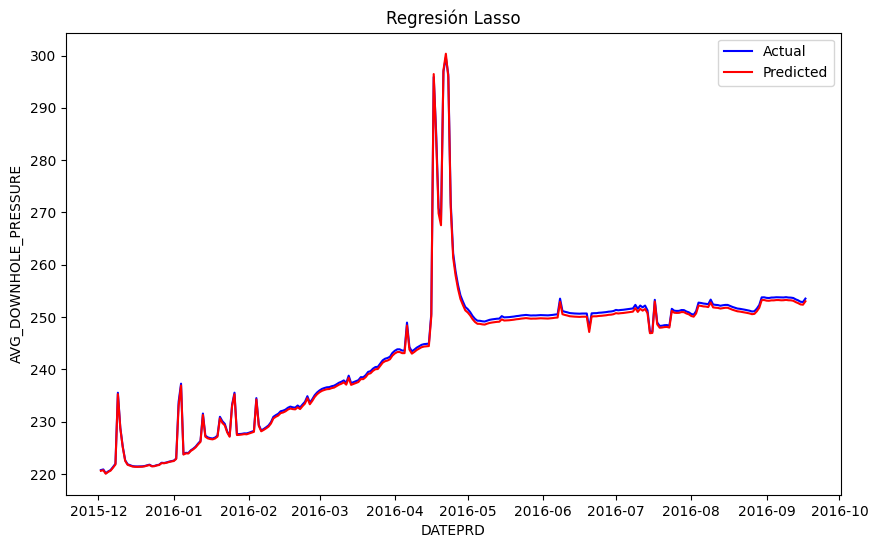

In [152]:
import matplotlib.pyplot as plt
import pandas as pd

# Supongamos que results_df contiene tus datos de resultados

# Graficar los resultados
plt.figure(figsize=(10, 6))

plt.plot(results_test['Date'], results_test['Actual'], label='Actual',color='Blue')
plt.plot(results_test['Date'], results_test['Predicted'], label='Predicted',color='red')

plt.title('Regresión Lasso')
plt.xlabel('DATEPRD')
plt.ylabel('AVG_DOWNHOLE_PRESSURE')
plt.legend()

plt.show()

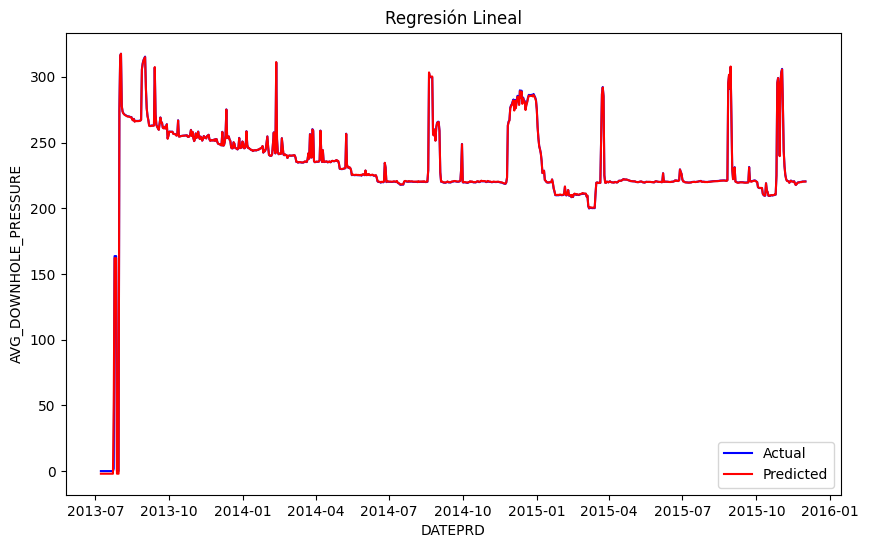

In [118]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(results_train['Date'], results_train['Actual'], label='Actual',color='Blue')
plt.plot(results_train['Date'], results_train['Predicted'], label='Predicted', color='Red')
plt.title('Regresión Lineal')
plt.xlabel('DATEPRD')
plt.ylabel('AVG_DOWNHOLE_PRESSURE')
plt.legend()
plt.show()

**Regresion Elastinet**

In [153]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Supongamos que 'newdfmodel' contiene tus datos originales

# Tomar los datos de los pozos 2 a 4, ya que tienen el menor número de valores faltantes
newdfmodel.reset_index(drop=True, inplace=True)
fdf = newdfmodel.loc[746:1910]

X = fdf.drop(['AVG_DOWNHOLE_PRESSURE'], axis=1)
y = fdf[['AVG_DOWNHOLE_PRESSURE']]

# Definir el número de divisiones para que el conjunto de prueba sea aproximadamente el 25% de los datos
n_splits = 3

# Definir la división temporal utilizando TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=n_splits)

# Inicializar listas para almacenar las métricas de entrenamiento y de prueba en cada iteración
train_scores = []
test_scores = []

# Iterar sobre las divisiones temporales y entrenar/evaluar el modelo
for train_index, test_index in time_series_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Eliminar columnas que no deben ir para la corrida del modelo
    x_train_final = X_train.drop(['DATEPRD'], axis=1)
    x_test_final = X_test.drop(['DATEPRD'], axis=1)
    y_test_final = y_test['AVG_DOWNHOLE_PRESSURE']
    y_train_final = y_train['AVG_DOWNHOLE_PRESSURE']

    elasticnet_model = ElasticNet(alpha=1, l1_ratio=0.5)
    elasticnet_model.fit(x_train_final, y_train_final)


     # Hacer predicciones en los conjuntos de entrenamiento y de prueba
    train_predictions = elasticnet_model.predict(x_train_final)
    test_predictions = elasticnet_model.predict(x_test_final)

    # Calcular métricas de entrenamiento y de prueba
    train_mse = mean_squared_error(y_train_final, train_predictions)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train_final, train_predictions)
    train_r2 = r2_score(y_train_final,train_predictions)

    test_mse = mean_squared_error(y_test_final, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test_final, test_predictions)
    test_r2 = r2_score(y_test_final, test_predictions)

    # Agregar las métricas a las listas
    train_scores.append((train_mse, train_rmse, train_mae, train_r2))
    test_scores.append((test_mse, test_rmse, test_mae, test_r2))

    # Convertir las listas de métricas en un DataFrame
metrics_df3 = pd.DataFrame({
    'Train MSE': [score[0] for score in train_scores],
    'Train RMSE': [score[1] for score in train_scores],
    'Train MAE': [score[2] for score in train_scores],
    'Train R2': [score[3] for score in train_scores],
    'Test MSE': [score[0] for score in test_scores],
    'Test RMSE': [score[1] for score in test_scores],
    'Test MAE': [score[2] for score in test_scores],
    'Test R2': [score[3] for score in test_scores]
})


In [154]:
metrics_df3

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,4.512370,2.124234,0.866189,0.998962,6.165674,2.483078,1.413017,0.988687
1,3.352302,1.830929,0.583356,0.998632,15.723871,3.965334,3.409699,0.948704
2,2.779265,1.667113,0.431780,0.998423,1.512826,1.229970,1.084759,0.991482


In [155]:
avg_metrics=metrics_df3.mean()
avg_metrics

Train MSE     3.547979
Train RMSE    1.874092
Train MAE     0.627108
Train R2      0.998672
Test MSE      7.800790
Test RMSE     2.559460
Test MAE      1.969158
Test R2       0.976291
dtype: float64

In [156]:
# Calcular el promedio de las métricas
import pandas as pd

# Suponiendo que avg_metrics es un objeto Series que contiene los promedios de las métricas
avg_metrics_df = avg_metrics.to_frame().T
avg_metrics_df

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,3.547979,1.874092,0.627108,0.998672,7.80079,2.55946,1.969158,0.976291


In [157]:
#Obtener las fechas correspondientes al conjunto de prueba
test_dates = X_test['DATEPRD']
train_dates= X_train['DATEPRD']

    # Crear un DataFrame con las fechas, predicciones y valores reales
results_train=pd.DataFrame({'Date': train_dates, 'Predicted': train_predictions , 'Actual': y_train_final})
results_test = pd.DataFrame({'Date': test_dates, 'Predicted': test_predictions , 'Actual': y_test_final})


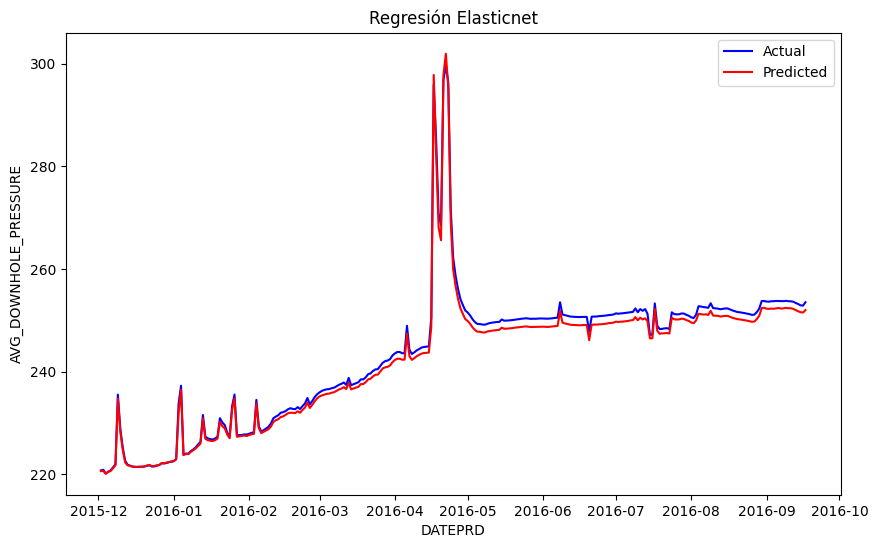

In [158]:
import matplotlib.pyplot as plt
import pandas as pd

# Supongamos que results_df contiene tus datos de resultados

# Graficar los resultados
plt.figure(figsize=(10, 6))

plt.plot(results_test['Date'], results_test['Actual'], label='Actual',color='Blue')
plt.plot(results_test['Date'], results_test['Predicted'], label='Predicted',color='red')

plt.title('Regresión Elasticnet')
plt.xlabel('DATEPRD')
plt.ylabel('AVG_DOWNHOLE_PRESSURE')
plt.legend()

plt.show()